<a href="https://colab.research.google.com/github/OLIVeNAKs/API/blob/master/Densenet_with_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# create helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix

--2024-02-22 10:42:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 10:42:59 (52.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import pandas as pd

# load metadata
df_norm = pd.read_excel('/content/drive/MyDrive/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [ ]:
# Example of metadata
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [ ]:
# Join both normal and tuberculosis excels
# create Label feature ['Tuberculosis']
df_norm['Tuberculosis'] = np.float(0)
df_tb['Tuberculosis'] = np.float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Rename column
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [ ]:
# Walk through directory
ds = "/content/drive/MyDrive/TB_Chest_Radiography_Database"
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

NameError: name 'walk_through_dir' is not defined

In [ ]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')

In [ ]:
# Map train validation test directories

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")



In [ ]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')

  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)


split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [ ]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):

    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [ ]:
len(os.listdir(IMAGE_DIR))

4200

In [ ]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]

    return df_res

In [ ]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [ ]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [ ]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4199


In [ ]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [ ]:
train_norm[:5]

['./training/Normal/Normal-1958.png',
 './training/Normal/Normal-804.png',
 './training/Normal/Normal-1001.png',
 './training/Normal/Normal-3334.png',
 './training/Normal/Normal-1285.png']

Normal


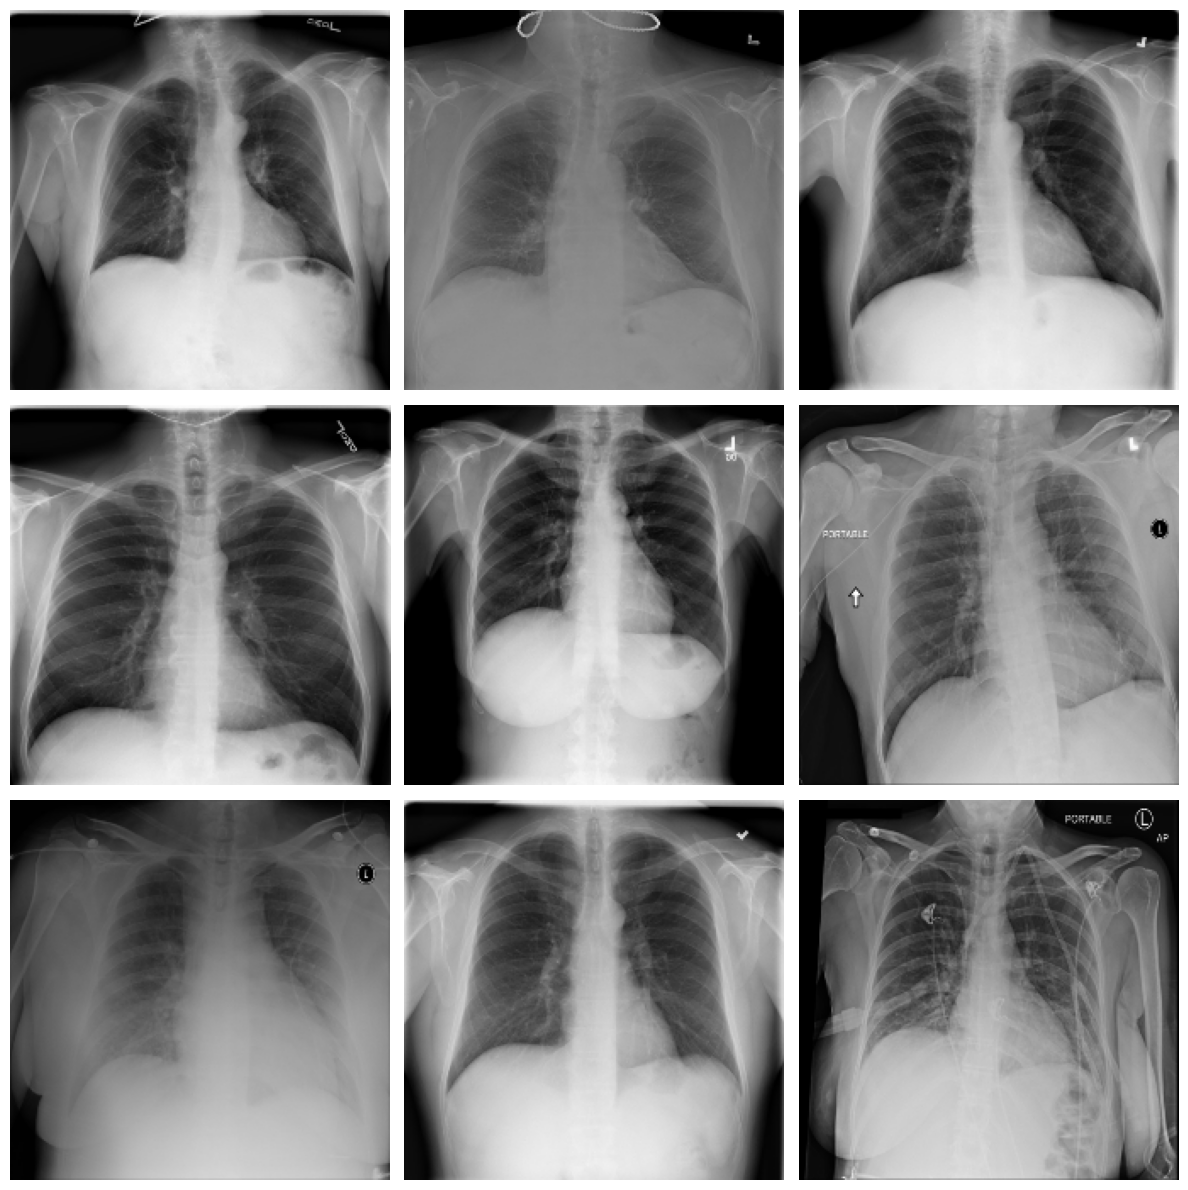

In [ ]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


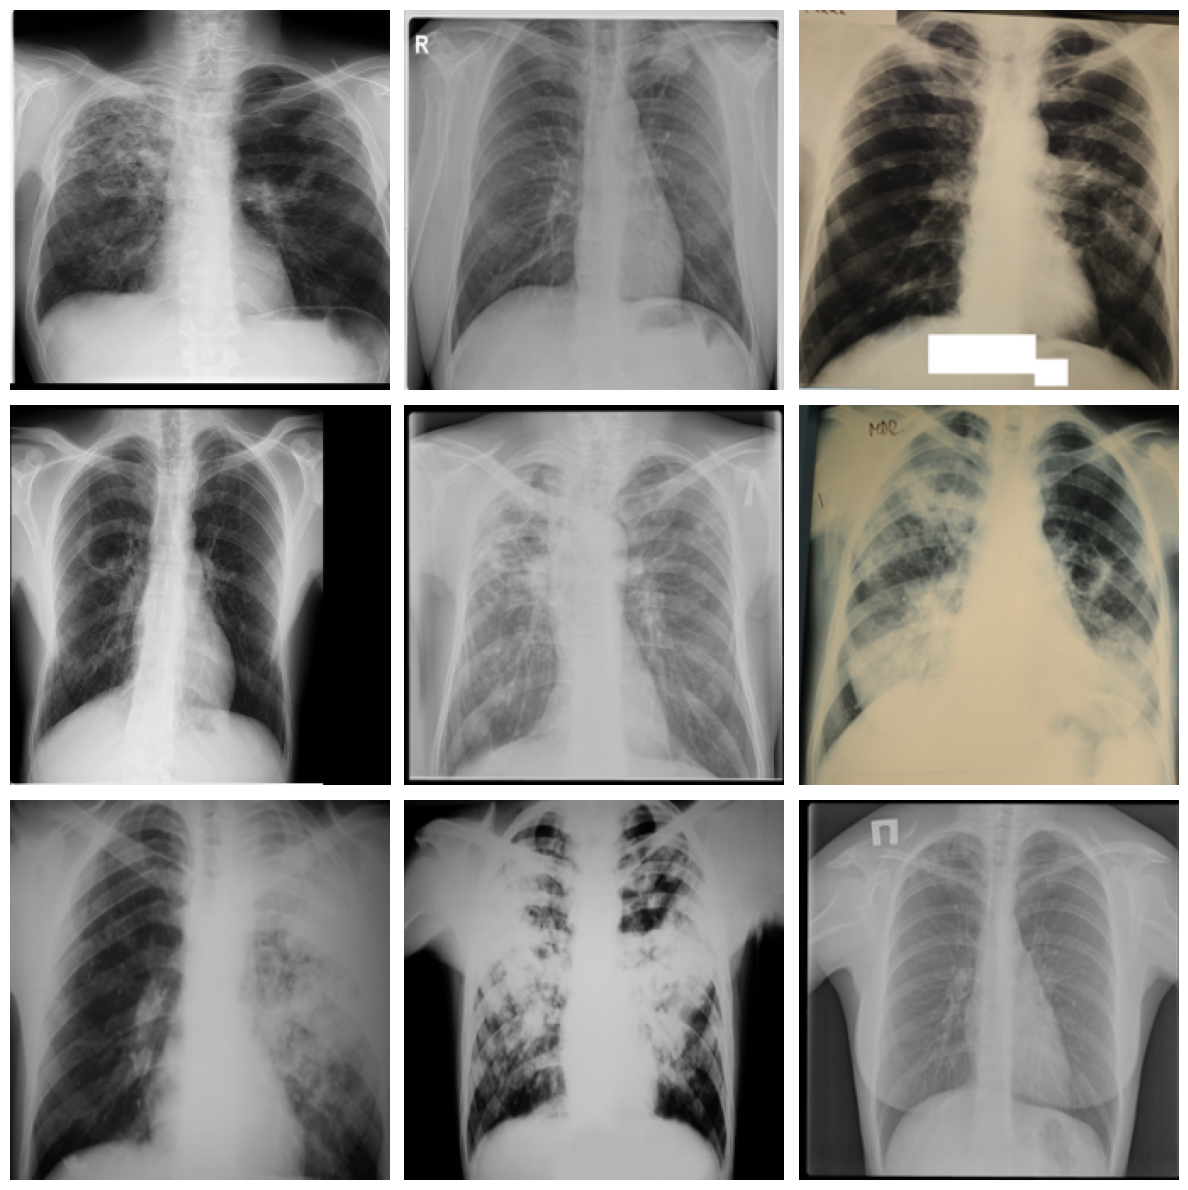

In [ ]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.

    print("getting train generator...")
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))



    return train_generator

In [ ]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    # This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return val_generator, test_generator

In [ ]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3359 validated image filenames.
getting val and test generators...
Found 3359 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


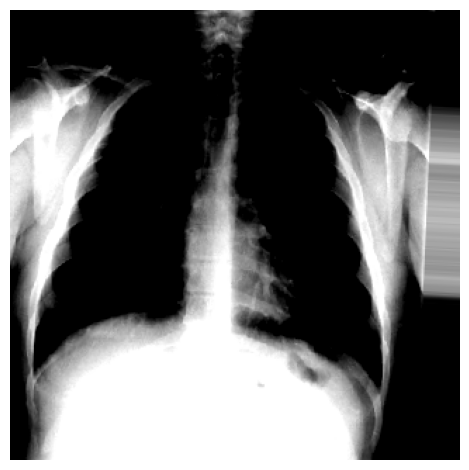

Image shape (320, 320, 3)


In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

In [ ]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [ ]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [ ]:
# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0

        # for each class, add average weighted loss for that class
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon)
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon)))
        return loss

    return weighted_loss

In [ ]:
## create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=["accuracy","AUC"])

In [ ]:
# callbacks

checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
#RLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 2, min_lr =0.001)
#ES = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 2)


In [ ]:
# fit model
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=100,
                              validation_steps= 30,
                              epochs = 8,
                              callbacks = [MC])

Epoch 1/8
100/100 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.8598 - auc: 0.9142 
Epoch 1: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 1254s 12s/step - loss: 0.1165 - accuracy: 0.8598 - auc: 0.9142 - val_loss: 2.2235 - val_accuracy: 0.8167 - val_auc: 0.5114
Epoch 2/8
100/100 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.8188 - auc: 0.8785 
Epoch 2: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 1203s 12s/step - loss: 0.1388 - accuracy: 0.8188 - auc: 0.8785 - val_loss: 0.3791 - val_accuracy: 0.5083 - val_auc: 0.8328
Epoch 3/8
100/100 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9450 - auc: 0.9843 
Epoch 3: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 1183s 12s/step - loss: 0.0435 - accuracy: 0.9450 - auc: 0.9843 - val_loss: 0.5866 - val_accuracy: 0.8792 - val_auc: 0.8621
Epoch 4/8
100/100 [===============

1/1 [==============================] - 2s 2s/step


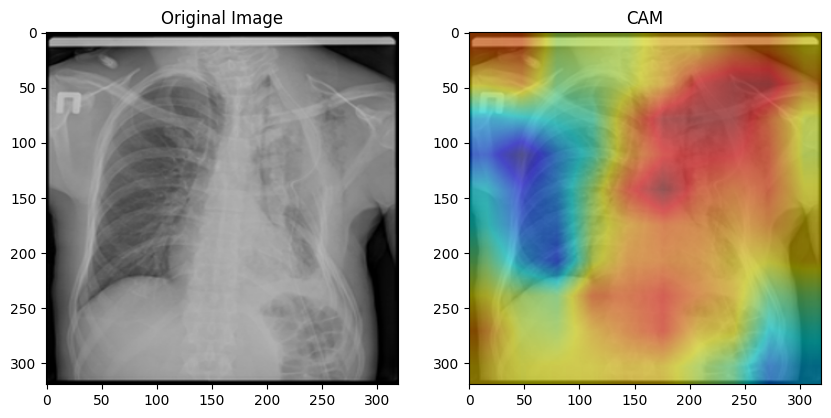

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess your image dataset
directory_path = '/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis/'
images = []
labels = []

for filename in os.listdir(directory_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image = cv2.imread(os.path.join(directory_path, filename))
        image = cv2.resize(image, (320, 320))
        image = image / 255.0
        images.append(image)
        if "tuberculosis" in filename:
            labels.append(1)
        else:
            labels.append(0)

X = np.array(images)
y = np.array(labels)

# Create and compile the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (you can adjust this part as needed)
#model.fit(X, y, epochs=8, validation_split=0.2)

# Get the index of the last convolutional layer
last_conv_layer_idx = [i for i, layer in enumerate(model.layers) if isinstance(layer, GlobalAveragePooling2D)][0] - 1

# Create a model that maps the input image to the activations of the last convolutional layer
cam_model = Model(inputs=model.input, outputs=(model.layers[last_conv_layer_idx].output, model.output))

# Make predictions on the test set
preds = model.predict(X)

# Get the class activation map (CAM) for a sample image
sample_idx = 0  # Change this to the index of the sample image you want to visualize
sample_image = X[sample_idx][np.newaxis, ...]
last_conv_output, pred = cam_model.predict(sample_image)
class_weights = model.layers[-1].get_weights()[0]
cam = np.dot(last_conv_output, class_weights)

# Upsample the CAM to match the size of the input image
upsampled_cam = cv2.resize(cam[0], (320, 320))

# Normalize the CAM
heatmap = upsampled_cam - np.min(upsampled_cam)
heatmap /= np.max(heatmap)

# Overlay the heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed_img = cv2.addWeighted((X[sample_idx] * 255).astype('uint8'), 0.5, heatmap, 0.5, 0)

# Plot the original image and the superimposed image with the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[sample_idx])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('CAM')

plt.show()
